<a href="https://colab.research.google.com/github/bishr-ab/ReinforcementLearning/blob/main/DynamicProgGridWorldPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np 
import matplotlib.pyplot as plt # Graphical library

# Lab Assignment 2 :  
See pdf for instructions


## Helper Functions


In [26]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this lab assessment

class GraphicsGridWorld(object):

  def __init__(self, shape, locations, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    # Ensure all inputs are valids using the is_valid_grid function
    is_valid_grid(shape, 0, obstacle_locs, absorbing_locs, absorbing_rewards)

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 1

    # Absorbing states
    self.absorbers = np.zeros(self.shape)
    for ab in absorbing_locs:
      self.absorbers[ab] = -1

    # Rewards
    self.rewarders = np.zeros(self.shape)
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = absorbing_rewards[i]

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Grid topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(self.walls)
    plt.title('Obstacles')
    plt.subplot(1,3,2)
    plt.imshow(self.absorbers)
    plt.title('Absorbing states')
    plt.subplot(1,3,3)
    plt.imshow(self.rewarders)
    plt.title('Reward states')
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure()
    plt.imshow(self.walls + self.rewarders + self.absorbers) # Create the graph of the grid
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure()
    plt.imshow(self.walls + self.rewarders + self.absorbers) # Create the graph of the grid
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


In [27]:
# Here, we define some functions used across the code
# YOU DO NOT NEED to understand it to work on this lab assessment

def is_valid_grid(shape, prob_success, obstacle_locs, absorbing_locs, absorbing_rewards):
  """
  Ensure the property defining the grid are all valid
  inputs: all properties to initialise a GridWorld (see GridWorld class)
  outputs: /
  """
  assert len(shape) == 2, "The grid should be two dimensions."
  assert (prob_success <= 1) and (prob_success >= 0), "Probability of action success should be in [0, 1]."
  for obstacle_loc in obstacle_locs:
    assert len(obstacle_loc) == 2, "The obstacle locations should have two coordinates."
    assert (obstacle_loc[0] < shape[0]) and (obstacle_loc[1] < shape[1]), "The obstacle locations should be inside the grid."
  assert len(absorbing_locs) == len(absorbing_rewards), "The absorbing_locs and absorbing_rewards should have the same length."
  for absorbing_loc in absorbing_locs:
    assert len(absorbing_loc) == 2, "The absorbing locations should have two coordinates."
    assert (absorbing_loc[0] < shape[0]) and (absorbing_loc[1] < shape[1]), "The absorbing locations should be inside the grid."

## GridWorld

In [31]:
# This class define the Grid world

class GridWorld(object):

  def __init__(self,
               shape = (5,5), 
               prob_success = 0.7,
               obstacle_locs = [(1,1),(2,1),(2,3)], 
               absorbing_locs = [(4,0),(4,1),(4,2),(4,3),(4,4)], 
               absorbing_rewards = [-10, -10, -10, -10, 10]  
              ):
    """
    GridWorld initialisation
    input: 
      - shape {tuple} -- GridWorld shape (height, width)
      - prob_success {float} -- probability of success when taking an action, used to fill the transition matrix
      - obstacle_locs {list of tuples} -- location of all obstacles of the grid: [(obstacle 1), (obstacle 2), ...] 
      - absorbing_locs {list of tuples} -- location of all absorbing states of the grid: [(state 1), (state 2), ...]
      - absorbing_rewards {list of float} -- reward corresponding to each absorbing state of the grid: [reward 1, reward 2, ...]
    output: /
    """
      
    # Ensure all inputs are valids using the is_valid_grid function
    is_valid_grid(shape, prob_success, obstacle_locs, absorbing_locs, absorbing_rewards)

    # Setting inputs as attributes
    self.shape = shape
    self.prob_success = prob_success
    self.obstacle_locs = obstacle_locs
    self.absorbing_locs = absorbing_locs
    self.absorbing_rewards = absorbing_rewards

    # Actions
    self.action_size = 4
    self.direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self.locations = self.fill_in_states()
    self.state_size = len(self.locations)
    self.neighbours = self.fill_in_neighbours()
    self.absorbing = self.fill_in_absorbing()

    # Transition and reward matrices
    self.T = self.fill_in_transition()
    self.R = self.fill_in_reward()

    # Creating the graphical grid world
    self.graphics = GraphicsGridWorld(self.shape, self.locations, self.obstacle_locs, self.absorbing_locs, self.absorbing_rewards, self.absorbing)


  def is_location(self, loc):
    """
    Is the location a valid state (not out of grid and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self.shape[0]-1 or loc[1] > self.shape[1]-1):
      return False
    elif (loc in self.obstacle_locs):
      return False
    else:
      return True


  def get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self.locations.index(tuple(loc))


  def get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self.locations[state]


  def fill_in_states(self):
    """
    Build the states numbers
    input: /
    output: locations {list of tuples} -- mapping from location to state number
    """
    
    locations = []
    for i in range (self.shape[0]):
      for j in range (self.shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self.is_location(loc):
          locations.append(loc)
    return locations


  def fill_in_neighbours(self):
    """
    Build the neighbouring states in the grid
    input: /
    output: neighbours {np.array} -- matrix containing the state number of the neighbours in each direction of all states
    """
   
    # Each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    neighbours = np.zeros((self.state_size, 4)) 
    
    for state in range(self.state_size):
      loc = self.get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self.is_location(neighbour):
        neighbours[state][self.direction_names.index('N')] = self.get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        neighbours[state][self.direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self.is_location(neighbour):
        neighbours[state][self.direction_names.index('E')] = self.get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        neighbours[state][self.direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self.is_location(neighbour):
        neighbours[state][self.direction_names.index('S')] = self.get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        neighbours[state][self.direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self.is_location(neighbour):
        neighbours[state][self.direction_names.index('W')] = self.get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        neighbours[state][self.direction_names.index('W')] = state

    return neighbours


  def fill_in_absorbing(self):
    """
    Translate absorbing locations into absorbing state indices
    input: /
    output: absorbing {np.array} -- array with value 1 when the state is absorbing the state number of the neighbours in each direction of all states
    """
    absorbing = np.zeros((1, self.state_size))
    for a in self.absorbing_locs:
      absorbing_state = self.get_state_from_loc(a)
      absorbing[0, absorbing_state] = 1
    return absorbing



  # DONE
  def fill_in_transition(self):
    """
    Compute the transition matrix of the grid
    input: /
    output: T {np.array} -- the transition matrix of the grid
    """
    T = np.zeros((self.state_size, self.state_size, self.action_size)) # Empty matrix of dimension S*S*A
    for action in range(self.action_size):
      for outcome in range(len(self.direction_names)):
        if action == outcome:
          prob = 1.0-((3.0*self.prob_success)/3.0) # MS said it could be 1 - 3(1-prob_success)/3 to guarantee sum of 1 in probability and avoid rounding error, but theoritically this is correct
        else:
          prob = (1.0-self.prob_success)/3.0 # as per problem statement, (1-p)/3 if not designated action

        # to fill in transition matrix with our result: 
        for prior_state in range(self.state_size):
          if not self.absorbing[0, prior_state]:
            post_state = int(self.neighbours[prior_state,outcome])
            T[prior_state, post_state, action] = T[prior_state, post_state, action] + prob # I assume this is equivalent to T[prior_state, post_state, action] += prob but dont think so
            # 3rd dimension of t matrix corresponds to actions 
    return T
    
  # DONE
  def fill_in_reward(self):
    """
    Compute the reward matrix of the grid
    input: /
    output: R {np.array} -- the reward matrix of the grid
    """
    R = np.zeros((self.state_size, self.state_size, self.action_size)) # empty matrix of S*S*A dimensions

    # for this problem, the reward is 0 for white boxes and -10 for absorbing states
    # So we only really want to fill in the reward matrix for the absorbing states
    
    for i in range(len(self.absorbing_rewards)):
      state_absorbing_reward = self.get_state_from_loc(self.absorbing_locs[i]) # This gets me the locations of the absorbing states, and then converts them into states. 
      # R = [pre reward (irrelevant), post reward (relevant), action (irrelevant)]
      R[:,state_absorbing_reward,:] = self.absorbing_rewards[i]
    return R





  # DONE
  def policy_evaluation(self, policy, threshold = 0.0001, gamma = 0.8):
    """
    Policy evaluation on GridWorld
    input: 
      - policy {np.array} -- policy to evaluate
      - threshold {float} -- threshold value used to stop the policy evaluation algorithm
      - gamma {float} -- discount factor
    output: 
      - V {np.array} -- value function corresponding to the policy 
      - epochs {int} -- number of epochs to find this value function
    """
    
    # Ensure inputs are valid
    assert (policy.shape[0] == self.state_size) and (policy.shape[1] == self.action_size), "The dimensions of the policy are not valid."
    assert (gamma <=1) and (gamma >= 0), "Discount factor should be in [0, 1]."

    # Initialisation
    delta = 2*threshold # Ensure delta is bigger than the threshold to start the loop
    V = np.zeros(self.state_size) # Initialise value function to 0 and stick with it 
    epoch = 0
    VNew = np.copy(V) # Make copy which we use to store update on

    # Apply iterative policy evaluation from MDP lecture

    while delta > threshold:
      epoch+=1

      for priorState in range(self.state_size):
        if not self.absorbing[0, priorState]:
          tmpV = 0
          for action in range(self.action_size):
            tmpQ = 0
            for postState in range(self.state_size):
              tmpQ = tmpQ + (self.T[priorState, postState, action]*(self.R[priorState, postState, action]+(gamma*V[postState])))
            tmpV = policy[priorState, action]*tmpQ
          VNew[priorState] = tmpV
      delta = max(abs(V-VNew))
      V = np.copy(VNew)
            
    return V, epoch

  # [Action required]
  def policy_iteration(self, threshold = 0.0001, gamma = 0.8):
    """
    Policy iteration on GridWorld
    input: 
      - threshold {float} -- threshold value used to stop the policy iteration algorithm
      - gamma {float} -- discount factor
    output:
      - policy {np.array} -- policy found using the policy iteration algorithm
      - V {np.array} -- value function corresponding to the policy 
      - epochs {int} -- number of epochs to find this policy
    """

    # Ensure gamma value is valid
    assert (gamma <=1) and (gamma >= 0), "Discount factor should be in [0, 1]."

    # Initialisation
    policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
    policy[:, 0] = 1 # Initialise policy to choose action 1 systematically
    V = np.zeros(self.state_size) # Initialise value function to 0  
    epochs = 0
    policy_stable = False # Condition to stop the main loop

    #### 
    # Add your code here
    # Hint! You might need: self.state_size, self.action_size, self.T, self.R, self.absorbing, self.policy_evaluation()
    ####
            
    return policy, V, epochs
 
  # [Action required]
  def value_iteration(self, threshold = 0.0001, gamma = 0.8):
    """
    Value iteration on GridWorld
    input: 
      - threshold {float} -- threshold value used to stop the value iteration algorithm
      - gamma {float} -- discount factor
    output: 
      - policy {np.array} -- optimal policy found using the value iteration algorithm
      - V {np.array} -- value function corresponding to the policy
      - epochs {int} -- number of epochs to find this policy
    """

    # Ensure gamma value is valid
    assert (gamma <=1) and (gamma >= 0), "Discount factor should be in [0, 1]."

    # Initialisation
    epochs = 0
    delta = threshold # Setting value of delta to go through the first breaking condition
    V = np.zeros(self.state_size) # Initialise values at 0 for each state
    policy = np.zeros((self.state_size, self.action_size)) # Initialisation

    #### 
    # Add your code here
    # Hint! You might need: self.state_size, self.action_size, self.T, self.R, self.absorbing
    ####

    

    return policy, V, epochs

## Question 1: Grid World Definition


Creating the Grid world:



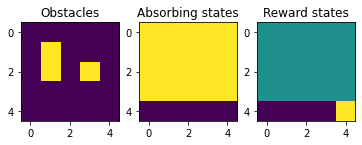


The first dimension of the transition matrix is: 22
The second dimension of the transition matrix is: 22
The third dimension of the transition matrix is: 4
The probability to go from state 0 to state 1 with action 0 (N) is: 0.10000000000000002


In [32]:
### Question 1: Grid World definition

# Define the grid
print("Creating the Grid world:\n")
grid = GridWorld()

# Exemple prints to help you understand the structure of the transition matrix
print("\nThe first dimension of the transition matrix is:", len(grid.T))
print("The second dimension of the transition matrix is:", len(grid.T[0]))
print("The third dimension of the transition matrix is:", len(grid.T[0,0]))
print("The probability to go from state 0 to state 1 with action 0 (N) is:", grid.T[0,1,0])

## Question 2: policy evaluation implementation


The value of the uniform policy with gamma = 0.8 is:

 [-2.6400000e-06 -1.6000000e-07 -2.4800000e-06 -1.6000000e-07
  2.2000000e-06 -1.2800000e-04 -1.2552000e-04 -5.2800000e-06
  1.0588000e-04 -5.9139600e-03 -5.9162800e-03  5.1956000e-03
 -2.7198176e-01 -2.7730524e-01 -2.7209272e-01 -2.6688428e-01
  2.3886952e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]


Its graphical representation is:



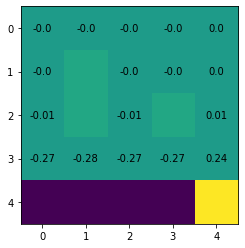


It took 5 epochs


In [33]:
### Question 2: policy evaluation implementation

# Define the policy
Policy = np.zeros((grid.state_size, grid.action_size))
Policy = Policy + 0.25

# Do not plot a graphical representation for this policy as it is fully random
#print("Considering the uniform (unbiased) policy:\n\n {}".format(Policy))

# Policy evaluation with threshold = 0.001 and gamma = 0.8
V, epochs = grid.policy_evaluation(Policy, threshold = 0.0001, gamma = 0.8)

# Plot value function
print("The value of the uniform policy with gamma = 0.8 is:\n\n {}".format(V))
print("\n\nIts graphical representation is:\n")
grid.graphics.draw_value(V)

# Plot number of epochs
print("\nIt took {} epochs".format(epochs))

## Question 3: impact of gamma on the policy evaluation


Impact of gamma value on the number of epochs needed for the policy evaluation algorithm:



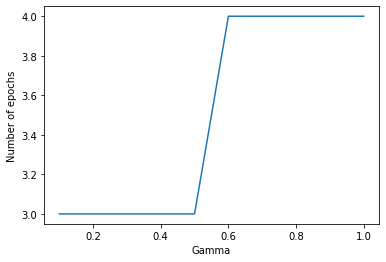


Graphical representation of the value function for each gamma:



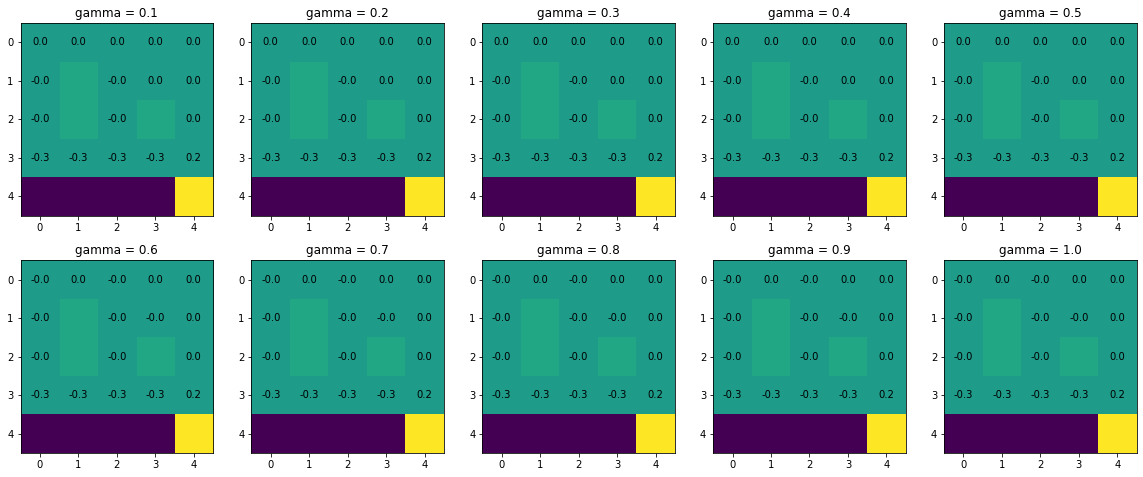

In [34]:
### Question 3: impact of gamma on the policy evaluation

gamma_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
epochs = []
values = []
titles = []

# Use policy evaluation for each gamma value
for gamma in gamma_range:
    V, epoch = grid.policy_evaluation(Policy, threshold = 0.001, gamma = gamma)
    epochs.append(epoch)
    values.append(V)
    titles.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("Impact of gamma value on the number of epochs needed for the policy evaluation algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs)
plt.xlabel("Gamma")
plt.ylabel("Number of epochs")
plt.show()

# Print all value functions for different values of gamma
print("\nGraphical representation of the value function for each gamma:\n")
grid.graphics.draw_value_grid(values, titles, 2, 5)

## Question 4: policy iteration implementation


In [ ]:
### Question 4: policy iteration implementation

# Policy iteration algorithm
policy, V, epochs = grid.policy_iteration(threshold = 0.001, gamma = 0.7)

# Plot value function for policy iteration
#print("The value of the optimal value computed using policy iteration is:\n\n {}\n\n".format(V))
print("The graphical representation of the optimal value computed using policy iteration is:\n")
grid.graphics.draw_value(V)

# Plot policy for policy iteration
#print("\n\nThe optimal policy using policy iteration is:\n\n {}\n\n".format(policy))
print("The graphical representation of the optimal policy using policy iteration is:\n")
grid.graphics.draw_policy(policy)

# Plot number of epochs
print("\nIt took {} epochs".format(epochs))

## Question 5:  impact of gamma on the policy iteration algorithm


In [ ]:
### Question 5:  impact of gamma on the policy iteration algorithm

gamma_range = [0, 0.2, 0.4, 0.6, 0.8]
epochs = []
policies = []
values = []
titles = []

# Use policy iteration for each gamma value
for gamma in gamma_range:
    policy, V, epoch = grid.policy_iteration(threshold = 0.001, gamma = gamma)
    epochs.append(epoch)
    policies.append(policy)
    values.append(V)
    titles.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("Impact of gamma value on the number of epochs needed for the policy iteration algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs)
plt.xlabel("Gamma range")
plt.ylabel("Number of epochs")
plt.show()

# Print all value functions and policies for different values of gamma
print("\nGraphical representation of the value function for each gamma:\n")
grid.graphics.draw_value_grid(values, titles, 1, 6)

print("\nGraphical representation of the policy for each gamma:\n")
grid.graphics.draw_policy_grid(policies, titles, 1, 6)

## Question 6: value iteration implementation


In [ ]:
### Question 6: value iteration implementation
policy, V, epochs = grid.value_iteration(threshold = 0.001, gamma = 0.7)

# Plot value function for policy iteration
#print("The value of the optimal policy computed using value iteration is:\n\n {}\n\n".format(V))
print("The graphical representation of the value of the optimal policy computed using value iteration is:\n")
grid.graphics.draw_value(V)

# Plot policy for value iteration
#print("\n\nThe optimal policy computed using value iteration is:\n\n {}\n\n".format(policy))
print("The graphical representation of the optimal policy computed using value iteration is:\n")
grid.graphics.draw_policy(policy)

# Plot number of epoch
print("\nIt took {} epochs".format(epochs))

## Question 7:  impact of gamma on the value iteration algorithm


In [ ]:
### Question 7:  impact of gamma on the value iteration algorithm
gamma_range = [0, 0.2, 0.4, 0.6, 0.8]
epochs = []
policies = []
values = []
titles = []

# Use value iteration for each gamma value
for gamma in gamma_range:
    policy, V, epoch = grid.value_iteration(threshold = 0.001, gamma = gamma)
    epochs.append(epoch)
    policies.append(policy)
    values.append(V)
    titles.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("Impact of gamma value on the number of epochs needed for the value iteration algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs)
plt.xlabel("Gamma range")
plt.ylabel("Number of epochs")
plt.show()

# Print all value functions and policies for different values of gamma
print("\nGraphical representation of the value function for each gamma:\n")
grid.graphics.draw_value_grid(values, titles, 1, 6)

print("\nGraphical representation of the policy for each gamma:\n")
grid.graphics.draw_policy_grid(policies, titles, 1, 6)